In [1]:
using JuMP, Plots, FastGaussQuadrature, Jacobi

# 最速降下問題の最適制御（擬スペクトル法）
$$
\dot{x} = \sqrt{2gy} \cos{\gamma}  \qquad x(0) = 0
$$
$$
\dot{y} = \sqrt{2gy} \sin{\gamma}  \qquad y(0) = 0
$$
$$
\dot{X} = F(X,U,t)
$$
で与えられるときに最短時間で
$$
x(t_f) = l \qquad  (l > 0)
$$
に到達するための制御変数 $\gamma$（flight-path angle）を求める．

本レポートにおいては，$g$を重力加速度とする．
計算にあたって使用した手法はPseudospectral Legendle-Gauss Method，プログラミング言語はJulia lang(v1.1)．最適化ソルバーについては `hogehoge` を使用した．

In [2]:
const g = 9.8    # [m/s^2]
"""dynamics"""
∂x(y, u) = sqrt(2g*y)*cos(u)
∂y(y, u) = sqrt(2g*y)*sin(u)
∂X(X,U,τ) = [∂x(X[2], U[1]), ∂y(X[2], U[1])]

∂y (generic function with 1 method)

$[-1,1]$で正規化した時刻$t_0,...,t_N$において，

$N$次のLegendre多項式 $L_N$を用いて関数
$$
\phi_{l}(t) :=\frac{1}{N(N+1) L_{N}\left(t_{l}\right)} \cdot \frac{\left(t^{2}-1\right) \dot{L}_{N}(t)}{t-t_{l}}
$$
$$
=\prod_{j=0, j \neq i}^{N} \frac{\tau-\tau_{j}}{\tau_{i}-\tau_{j}}
$$
を定義すると，
$$
\phi_{l}\left(t_{j}\right)=\left\{\begin{array}{ll}{1} & {\text { if } l=j} \\ {0} & {\text { if } l \neq j}\end{array}\right.
$$
となることがわかる．

ただし，$t_i$は$N$次のGauss-Legendre Quadratureの$i$番目のノード($N$次Legendre多項式の$i$番目の零点)である．

In [3]:
τ(t, T) = T*(t+1)/2
# ϕ(t, l, N) = (t^2-1)*dlegendre(t,N)/(N*(N+1)*legendre(gausslegendre(N)[1][l], N)*(t-gausslegendre(N)[1][l]))
ϕ(l, j) = l==j ? 1 : 0

ϕ (generic function with 1 method)

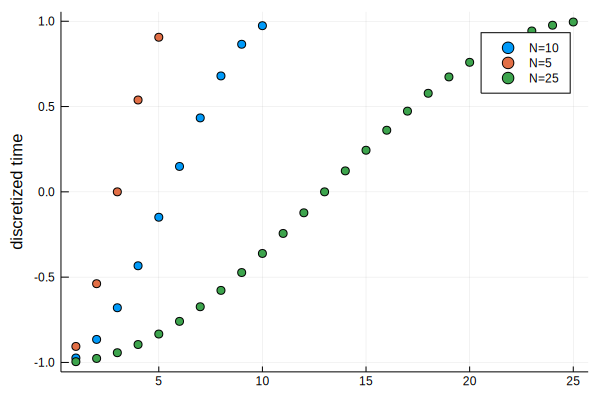

In [4]:
t10 = gausslegendre(10)[1]
t5  = gausslegendre(5 )[1]
t25 = gausslegendre(25)[1]
scatter(t10, label="N=10", ylabel="discretized time")
scatter!(t5, label="N=5" )
scatter!(t25,label="N=25")

したがって，元のダイナミクスについて，
$$
F^{N}(t) :=\sum_{l=0}^{N} F\left(t_{l}\right) \phi_{l}(t)
$$
$t$は離散化されているので，
$$
F^{N}\left(t_{k}\right)=F\left(t_{k}\right), \qquad k=0,1, \cdots, N
$$
とわかる．$x, y, u$についても同様に$\phi$を用いて離散化できる．

$\dot{F}$については，
$$
\dot{F}^{N}\left(t_{m}\right)=\sum_{l=0}^{N} D_{m l} F\left(t_{l}\right)
$$
で表される．ただし，
$$
D_{k i}=\dot{L}_{i}\left(\tau_{k}\right)=\sum_{l=0}^{N} \frac{\prod_{j=0, j \neq i, l}^{N}\left(\tau_{k}-\tau_{j}\right)}{\prod_{j=0, j \neq i}^{N}\left(\tau_{i}-\tau_{j}\right)}
$$
$$
k = 1, ..., N \quad and \quad i = 0, ..., N
$$
なる$(N,N+1)$行列である．

In [53]:
struct GPMsetting
    N::Int
    D::Matrix
    τ::Vector
    w::Vector
end
function GPMsetting(N)
    D = zeros(N,N+1)
    τ, w = gausslegendre(N)
    τ = append!(-1*ones(1), τ)
    τ = append!(τ, ones(1))
    for k in 2:N+1
        for l in 1:N+1
            if k==l
                D[k-1,l] = 0
                for m in 1:N+1
                    if m != k
                        D[k-1,l] += 1.0/(τ[k]-τ[m])
                    end
                end
            else
                D[k-1,l] = 1.0/(τ[l]-τ[k])
                for m in 1:N+1
                    if m != k && m != l
                        D[k-1,l] *= (τ[k]-τ[m])/(τ[l]-τ[m])
                    end
                end
            end
        end
    end
    return GPMsetting(N, D, τ, w)
end

GPMsetting

In [54]:
GPMsetting(10)

GPMsetting(10, [-24.1333 19.4152 … -0.0251783 0.00678669; 7.29211 -14.356 … 0.0418175 -0.0112322; … ; -7.29211 11.7442 … 3.97353 2.62303; 24.1333 -38.8372 … -32.1806 19.4152], [-1.0, -0.973907, -0.865063, -0.67941, -0.433395, -0.148874, 0.148874, 0.433395, 0.67941, 0.865063, 0.973907, 1.0], [0.0666713, 0.149451, 0.219086, 0.269267, 0.295524, 0.295524, 0.269267, 0.219086, 0.149451, 0.0666713])

離散化されたダイナミクスは，
$$
\sum_{i=0}^{N} D_{k i} \mathbf{X}_{i}-\frac{T}{2} \mathbf{f}\left(\mathbf{X}_{k}, \mathbf{U}_{k}, \tau_{k} ; T\right)=\mathbf{0} \qquad(k=1, \ldots, N)
$$
$$
\mathbf{X}_{f} \equiv \mathbf{X}_{0}+\frac{T}{2} \sum_{k=1}^{N} w_{k} \mathbf{f}\left(\mathbf{X}_{k}, \mathbf{U}_{k}, \tau_{k} ; T\right)
$$
目的関数はGauss-Lobattoの積分公式より，
$$
\int_{-1}^{1} g\left(x^{N}(t), y^{N}(t), u^{N}(t), t, T\right) d t=\sum_{k=0}^{N} g\left(x^{N}\left(t_{k}\right), y^{N}(t_k), u^{N}\left(t_{k}\right), t_{k}, T\right) w_{k}
$$
なる重み付き線形和で表される．ただし，
$$
w_{k}=\frac{2}{N(N+1)} \cdot \frac{1}{\left[L_{N}\left(t_{k}\right)\right]^{2}} \qquad k=0,1, \cdots, N
$$
なる，Gauss-Legendre quadratureの重みである．したがって，
$$
J=\Phi\left(\mathbf{X}_{0}, 0, \mathbf{X}_{f}, T\right)+\frac{T}{2} \sum_{k=1}^{N} w_{k} g\left(\mathbf{X}_{k}, \mathbf{U}_{k}, \tau_{k} ; T\right)
$$
制約条件は
$$
\mathbf{C}\left(\mathbf{X}_{k}, \mathbf{U}_{k}, \tau_{k} ; t_{0}, t_{f}\right) \leq \mathbf{0} \qquad(k=1, \ldots, N)
$$
となる．

初期値と最終値の拘束条件は，
$$
\phi\left(\mathbf{X}_{0}, t_{0}, \mathbf{X}_{f}, t_{f}\right)=\mathbf{0}
$$

In [55]:
DiscDynamics(X::Vector,U::Vector,t0, tf,f, set::GPMsetting) = sum(set.D*X,axis=1)-(tf-t0)/2*f(X,U,set.τ)
Xf(X::Vector,U::Vector,X₀, t0, tf, f, set::GPMsetting) = X₀ + (tf-t0)/2*sum(set.w*f(X,U,set.τ))
CostFun(X₀, t0, Xf, tf, g, set::GPMsetting) = Φ(X₀, t0, Xf, tf) + (tf-t0)/2*sum(set.w*g(X,U,set.τ))

CostFun (generic function with 1 method)

最適制御の問題は
$$
J^{N}(\alpha, \beta, T) :=h\left(a_{N}, T\right)+\sum_{k=0}^{N} g\left(a_{k}, b_{k}, t_{k}, T\right) w_{k}
$$
subject to
$$
A_{k} :=f\left(a_{k}, b_{k}, t_{k}, T\right)-d_{k}=0,(k=0,1, \cdots, N)
$$
を最小化させる最適な
$$
\alpha :=\left(a_{0}, a_{1}, \cdots, a_{N}\right), \quad \beta :=\left(b_{0}, b_{1}, \cdots, b_{N}\right), \quad T
$$
を探索する問題になる．

In [ ]:
function GaussLegendre_gamma(N,xf)
    set = GPMsetting(N)
end

### 参考文献
Elnagar, Gamal, Mohammad A. Kazemi, and Mohsen Razzaghi. "The pseudospectral Legendre method for discretizing optimal control problems." IEEE transactions on Automatic Control 40.10 (1995): 1793-1796.

Benson, David A., et al. "Direct trajectory optimization and costate estimation via an orthogonal collocation method." Journal of Guidance, Control, and Dynamics 29.6 (2006): 1435-1440.